In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from dotmap import DotMap

In [4]:
PROJECT_PATH = '../'
DATA_DIR = "/home/swei20/AE/data/"
# DATA_PATH = '/scratch/ceph/swei20/data/ae/dataset/test'
PCA_PATH = '/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/pca/spectra.h5'
SZALAY_PATH = os.path.join("/scratch/ceph/szalay/swei20/AE", 'pca.h5')
sys.path.insert(0, PROJECT_PATH)

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
import tensorflow as tf
# tf.enable_v2_behavior()
gpus = tf.config.list_physical_devices('GPU') 
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Loading Data

In [43]:
with h5py.File(PCA_PATH, 'r') as f:
#     flux = f['flux'][()]
#     flux_idx = f['flux_idx'][()]
    Fe_H = f['Fe_H'][()]
#     log_g = f['log_g'][()]
#     O_M = f['O_M'][()]
#     C_M = f['C_M'][()]
#     T_eff = f['T_eff'][()]
#     wave = f['wave'][()]
#     eigv = f['flux_eigv'][()]


In [32]:
(Fe, Te, Lg, CM, OM) =  np.where(flux_idx)

In [35]:
import pandas as pd

In [38]:
para = pd.DataFrame(data=np.transpose([Fe, Te, Lg, CM, OM]), columns = ["Fe", "Te", "Lg", "CM", "OM"])

In [44]:
Fe_H

array([-2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75, -0.5 ,
       -0.25,  0.  ,  0.25,  0.5 ,  0.75])

In [46]:
# OM_idx = 1
# CM_idx = 3
para1d  = para[(para["OM"] == 1 ) & (para["CM"] == 3)  & (para["Lg"] == 8) & (para["Fe"]==10)]

In [51]:
idx1d = para1d.index

In [8]:
DATA_PATH = os.path.join(DATA_DIR, 'pc32.h5')
with h5py.File(DATA_PATH, 'r') as f:
    flux = f['flux'][()]
#     flux32m = f['flux32m'][()]
#     flux32ms = f['flux32ms'][()]

In [24]:
# with h5py.File(DATA_PATH, 'a') as f:
#     f.create_dataset('fmean', data = f_mean, shape = (32,))
#     f.create_dataset('fm_std', data = std, shape = (1,))  

In [9]:
flux.shape

(116614, 32)

### LOADING MODEL

In [55]:
config_dict ={
    "data": {
      "dir":"./data",
      "filename": "pc32.h5",
      "train": "flux"
    },
    "model":{
      "aug": 1,
      "name": "eval",
      "input_dim": 32,
      "latent_dim": 8,
      "hidden_dims": [128, 64],
      "dropout": 0.0,
      "lr": 0.003,
      "reg1": 0.00001,
      "loss": "mse",
      "opt": "adam",
      "batchnorm": 0,
      "act_in": "leaky",
      "act_em": "leaky",
      "act_hd": "leaky"
    },
    "trainer":{
      "epoch": 1,
      "batch_size": 16,
      "validation_split":0.3,
      "verbose": 1,
      "save": 0
    },
    "callbacks":{
        "checkpoint_monitor": "val_loss",
        "checkpoint_mode": "min"
    }
}
config = DotMap(config_dict)

In [56]:
#  loss: 0.0113 
# - mean_squared_error: 0.0023 
# - val_loss: 0.0337 
# - val_mean_squared_error: 0.0248

In [57]:
from ae.model.simple_ae_model import SimpleAEModel
from ae.trainer.simple_ae_trainer import SimpleAETrainer

In [58]:
mm = SimpleAEModel()
mm.build_model(config)

In [59]:
MODEL_PATH="/home/swei20/AE/trained_model/ep500_mse_lr2_32_l8_h128_h64_INleEMleHDle_pc32_0703_212611/"
mm.load(MODEL_PATH)

Loading model checkpoint /home/swei20/AE/trained_model/ep500_mse_lr2_32_l8_h128_h64_INleEMleHDle_pc32_0703_212611/ ...

Model loaded


In [ ]:
data = flux
tt = SimpleAETrainer(mm, config)
history = tt.train((data, data), ep=1)

 796/5102 [===>..........................] - ETA: 11s - loss: 0.0105 - mean_squared_error: 0.0087

In [15]:
tt.eval(eigv)

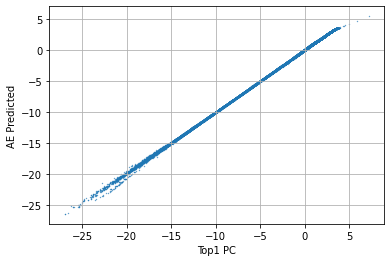

In [41]:
idx=0
plt.scatter(tt.x_train[:, idx],tt.ae_pred[:, idx], s=0.1)
# plt.plot(   s=0.1, c='k')
plt.xlabel(f"Top{idx+1} PC")
plt.ylabel("AE Predicted")

# plt.legend()
plt.grid(1)

In [59]:
def plot_err(org, rec):
    f, axs =  plt.subplots(8, 4,figsize=(20, 40))
    for idx, ax in enumerate(axs.flatten()):
        ax.scatter(org[:, idx],rec[:, idx], s=0.1, color  = 'r')
        ax.set_xlabel(f"PC - {idx + 1}")
        ax.set_ylabel(f"AE - {idx + 1} ")
        ax.grid(1)

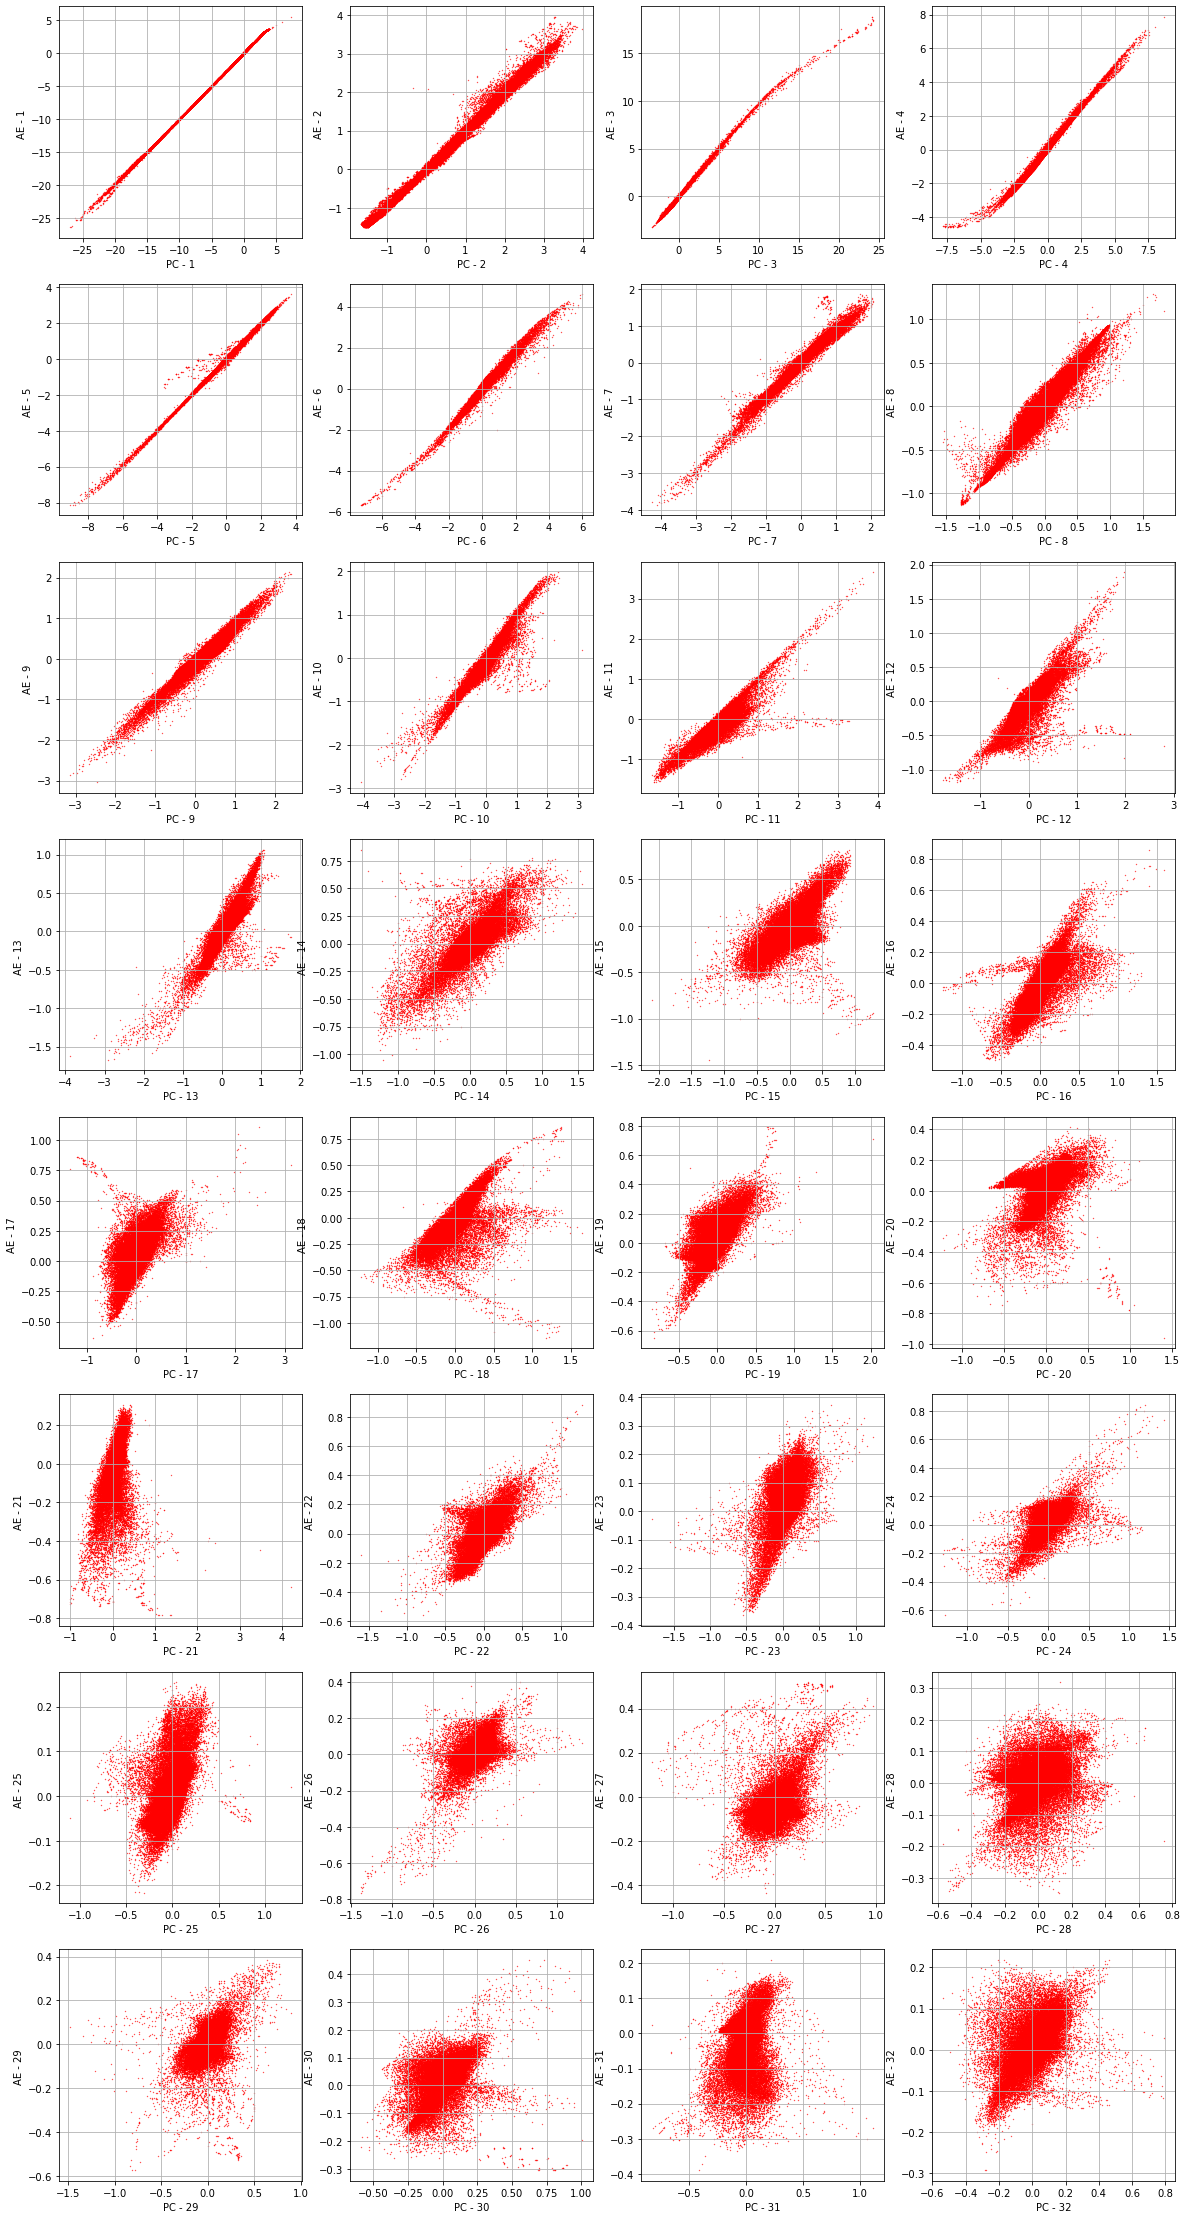

In [60]:
plot_err(tt.x_train, tt.ae_pred)

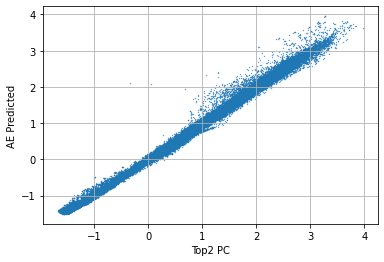

In [42]:
idx=1
plt.scatter(tt.x_train[:, idx],tt.ae_pred[:, idx], s=0.1)
# plt.plot(   s=0.1, c='k')
plt.xlabel(f"PC - {idx + 1}")
plt.ylabel(f"AE - {idx + 1} "`)

# plt.legend()
plt.grid(1)

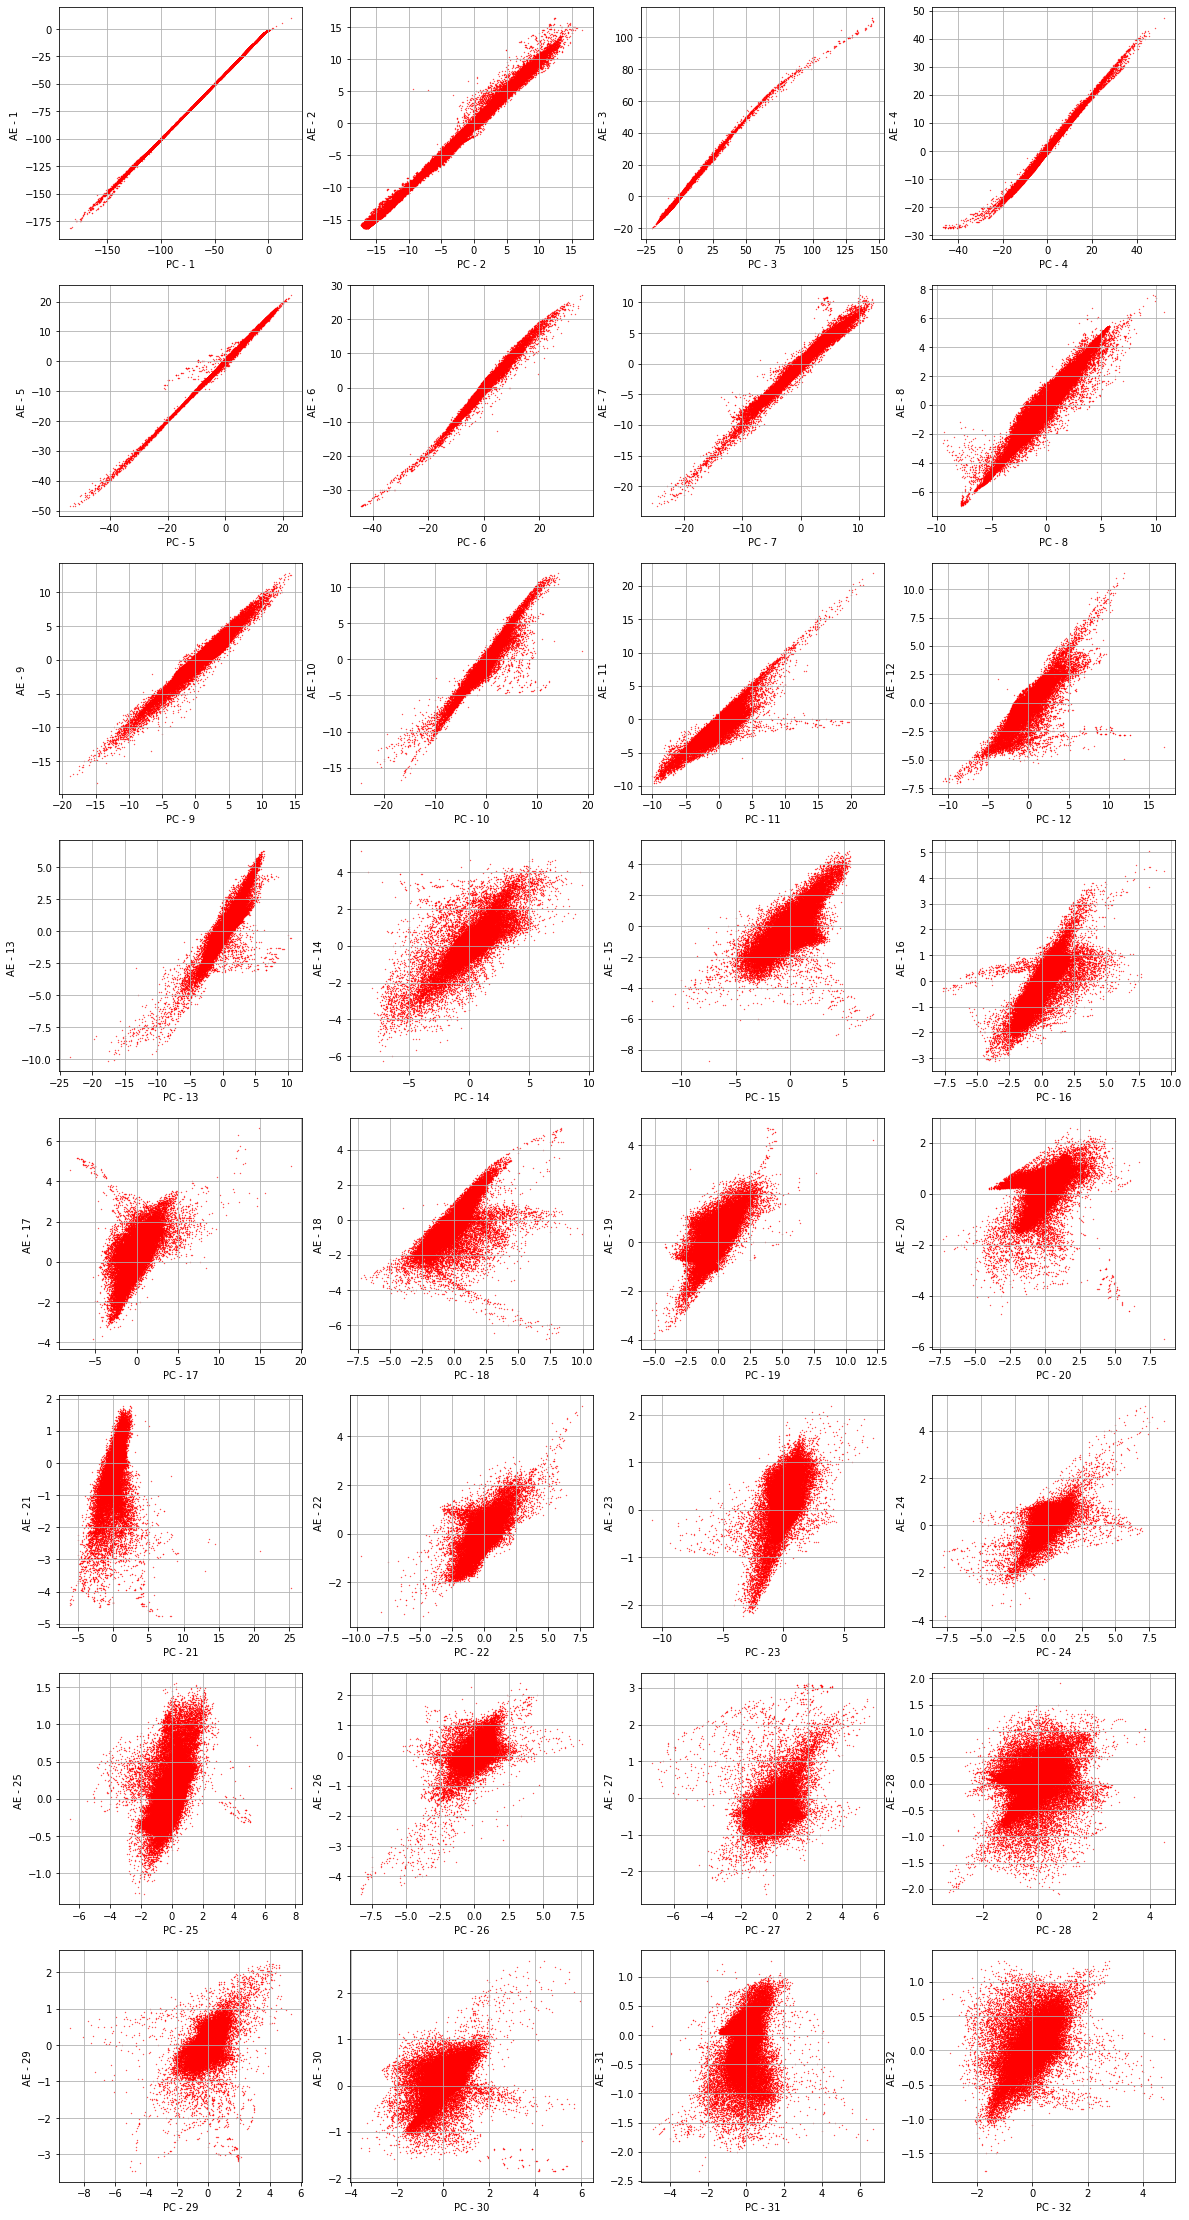

In [61]:
plot_err(flux, ae_pred1)

In [20]:
en32 = mm.encoder.predict(data)

In [23]:
s =np.linalg.svd(en32, compute_uv=False)

In [29]:
s.shape

(8,)

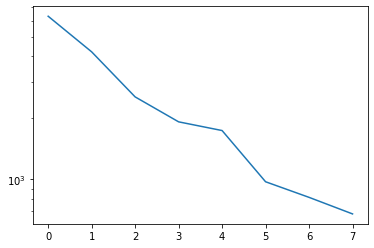

In [28]:
plt.plot( s )
# plt.xscale('log')
plt.yscale('log')

In [52]:
en1d = en32[idx1d,:]

In [54]:
en1d.shape

(66, 8)

In [ ]:
plt.plot()